### Imports & settings

In [19]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%reload_ext autoreload
%autoreload 2

import torch
from data_provider.data_factory import data_provider
from types import SimpleNamespace
from sklearn.metrics import mean_squared_error
from permutations import BEST_EXPS, SELECTED_EXPS
PERMUTATION_PATH = Path('./permutations')
FIG_PATH = Path('/home/admin/code/arnaud-odet/7_PhD/Collective_behavior/latex/articles')
EXP_SPECS = {0:{'model': 'best' , 'set': 'test', 'n_iter' : 4},
             1:{'model': 'best' , 'set': 'test', 'n_iter' : 20},
             2:{'model': 'best' , 'set': 'test', 'n_iter' : 3},
             3:{'model': 'best' , 'set': 'test', 'n_iter' : 10},
             4:{'model': 'selected' , 'set': 'test', 'n_iter' : 5},
             5:{'model': 'selected' , 'set': 'test', 'n_iter' : 5},
             6:{'model': 'selected' , 'set': 'test', 'n_iter' : 10},
             7:{'model': 'best' , 'set': 'train', 'n_iter' : 3},
             8:{'model': 'selected' , 'set': 'train', 'n_iter' : 3},
             9:{'model': 'selected_v2' , 'set': 'test', 'n_iter' : 3},
             10:{'model': 'selected_v2' , 'set': 'train', 'n_iter' : 3},
             11:{'model': 'selected_v3' , 'set': 'train', 'n_iter' : 3},
             12:{'model': 'selected_v3' , 'set': 'test', 'n_iter' : 5}
             }

# v0 uses local th_32 iTransformer
# v1 to 3 top performing models over all ths
# v4 uses short-life (12 epochs) top 4 Crossformer on th_32  
# v5 introduces selected models (within top5 with short life)
# v7 is over the train set.
# v9 introduces very short life model
# v11 is about best non crossformer performer

### Analysis

In [20]:
n_last_feat_most_imp = 0
n = 0
version_dict = {}
for f in os.listdir(PERMUTATION_PATH):
    X = np.load(PERMUTATION_PATH / f)
    n+=1
    if np.argmax(-X) == 60 :
        n_last_feat_most_imp += 1
        print(f)
        version_dict[f.split('_')[2]] = version_dict.get(f.split('_')[2], 0) + 1
print(f"{n_last_feat_most_imp/n:.2f} have most importance on the Performance feature")

dict(sorted(version_dict.items(), key=lambda item: item[1], reverse=True))

9_033_v5_5.npy
1_153_v4_5.npy
1_153_v0_4.npy
21_113_v12_5.npy
27_034_v3_10.npy
9_033_v6_10.npy
27_034_v2_3.npy
13_099_v5_5.npy
13_099_v8_1.npy
27_034_v7_3.npy
21_113_v3_10.npy
21_113_v7_3.npy
21_113_v11_3.npy
25_078_v12_5.npy
9_033_v4_5.npy
3_149_v11_3.npy
13_099_v6_10.npy
13_099_v8_3.npy
25_078_v11_3.npy
7_070_v11_3.npy
11_163_v5_5.npy
3_149_v12_5.npy
11_163_v6_10.npy
7_070_v12_5.npy
27_034_v1_20.npy
21_113_v2_3.npy
0.62 have most importance on the Performance feature


{'v12': 4,
 'v11': 4,
 'v5': 3,
 'v6': 3,
 'v4': 2,
 'v3': 2,
 'v2': 2,
 'v8': 2,
 'v7': 2,
 'v0': 1,
 'v1': 1}

In [26]:
def permutation_plot(th, v, display_header:bool = True, savefig:bool = True, which = 'best', sign:int = -1):
    exps = BEST_EXPS if which == 'best' else SELECTED_EXPS[int(which[-1])]
    print(exps)
    perm_imp = np.load(PERMUTATION_PATH / f"{exps[th]}_v{v}_{EXP_SPECS[v]['n_iter']}.npy")
    performance_feature_importance = sign * perm_imp[-1]
    print(f"Performance feature importance score = {performance_feature_importance:.2e}")
    pi_df = pd.DataFrame(data = sign * perm_imp[:-1], index = range(60), columns = ['permutation_importance'])
    pi_df['player'] = [(x // 4) +1 for x in pi_df.index]
    pi_df['kpi'] = [x % 4 for x in pi_df.index]
    kpi_map = {0: 'x', 1: 'y', 2: 'v', 3:'angle'}
    pi_df['kpi'] = pi_df['kpi'].map(kpi_map)
    if display_header:
        display(pi_df.head())
    fig, axs = plt.subplots(1,3,figsize = (20,5))
    sns.boxplot(data = pi_df, x = 'kpi', y = 'permutation_importance', ax = axs[0]);
    axs[0].set_xlabel("Feature type");
    axs[0].set_ylabel("Feature Importance");
    axs[0].set_title('Feature importance per feature type');
    axs[0].axhline(y=0, color='r', linestyle='--')
    axs[0].axhline(y=performance_feature_importance, color='g', linestyle=':')
    sns.barplot(data = pi_df, x = 'player', y = 'permutation_importance', ax = axs[1], errorbar=None);
    axs[1].set_xlabel("Player n°");
    axs[1].set_ylabel("Mean Feature Importance");
    axs[1].set_title('Feature importance per player');
    # axs[1].axhline(y=performance_feature_importance, color='g', linestyle=':')
    sns.heatmap(data= pi_df.pivot(index = 'player', columns = ['kpi'], values = 'permutation_importance'), cmap = 'coolwarm', ax = axs[2]);  
    axs[2].set_xlabel("Feature type");
    axs[2].set_ylabel("Player");
    axs[2].set_title('Feature importance heatmap');
    axs[2].axhline(y=8, color='black', linestyle='-')
    
    if savefig :
        plt.savefig(FIG_PATH / f'feature_importance_th{th}.png', dpi = 300)
    return pi_df

    

{16: '7_070', 32: '25_078', 64: '3_149', 128: '21_113'}
Performance feature importance score = 2.70e-02


,permutation_importance,player,kpi
0,0.000597,1,x
1,0.000180,1,y
2,-0.001055,1,v
3,-0.000247,1,angle
4,0.000585,2,x


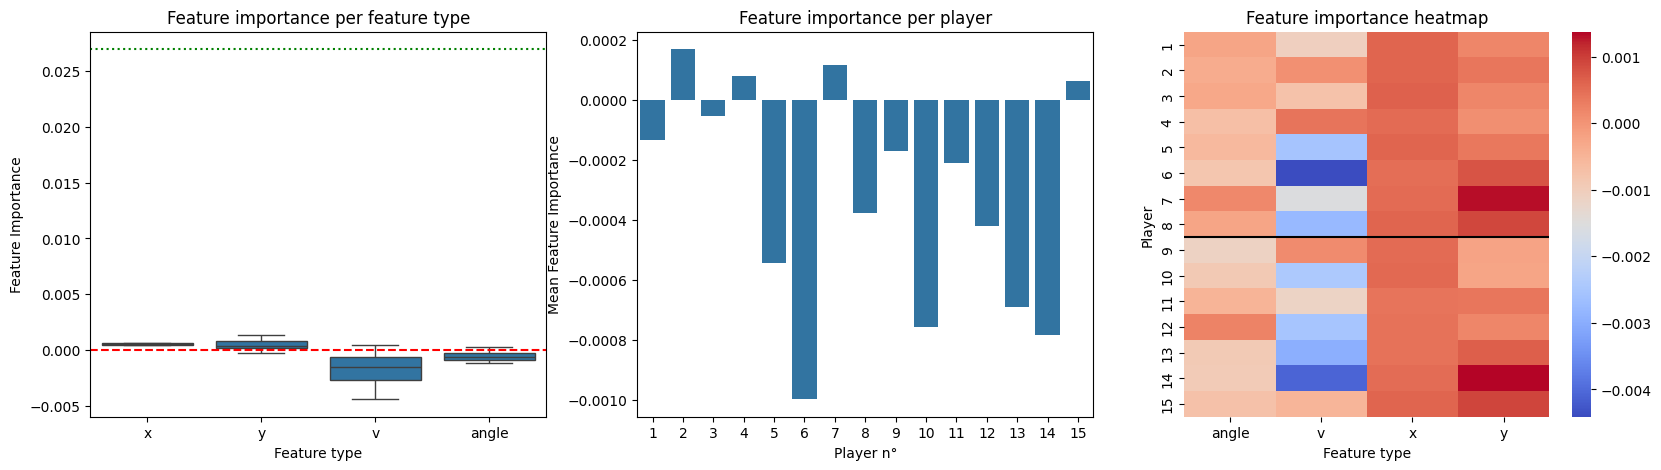

In [28]:
v = 12
th = 128
which = EXP_SPECS[v]['model']
pi_df = permutation_plot(th, v, display_header=True, savefig=False, which= which, sign = -1)